<a href="https://colab.research.google.com/github/TomPham204/thesis/blob/main/thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV2
from tensorflow.keras.optimizers import SGD

import numpy as np

In [ ]:
data_dir = './drive/MyDrive/TrashDataset/'
weight_dir = './drive/MyDrive/TrashModel/'
batch_size = 24
image_size = (224, 224)

**Data loading & augmentation**

In [ ]:
original_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
augmented_datagen  = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.85, 1.15],
)

all_data_generator = original_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

validation_generator = original_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

augmented_generator = augmented_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

combined_generator = original_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)
combined_steps_per_epoch = combined_generator.samples // batch_size

Found 4382 images belonging to 5 classes.
Found 1093 images belonging to 5 classes.
Found 5475 images belonging to 5 classes.
Found 4382 images belonging to 5 classes.


**Model initialization**

In [ ]:
base_model = MobileNetV2(weights='imagenet', classes=5, include_top=False, input_shape=(224, 224, 3))

blocks_to_freeze = len(base_model.layers) // 2

for layer in base_model.layers[:blocks_to_freeze]:
    layer.trainable = False

classifier = base_model.output
classifier = tf.keras.layers.GlobalAveragePooling2D()(classifier)
classifier = tf.keras.layers.Dense(512, activation='relu')(classifier)
predictions = tf.keras.layers.Dense(5, activation='softmax')(classifier)

optim = SGD(learning_rate=0.0001, momentum=0.9)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(weight_dir+'trash_classification_model-resume.h5', save_best_only=True, save_weights_only=False)
checkpoints=[model_checkpoint]

9406464/9406464 [==============================] - 0s 0us/step


**If !!checkpoint from last save**

In [ ]:
from datetime import date

try:
  saved_model = tf.keras.models.load_model('trash_classification_model.h5') | None

  if(saved_model != None):
    history = saved_model.fit(
        combined_generator,
        steps_per_epoch=combined_steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=25,
        callbacks=checkpoints
    )
    saved_model.save(f'trash_classification_model-{date.today()}.h5')
except:
  print('No saved weight')

No saved weight


**Training**

In [ ]:
history = model.fit(
    combined_generator,
    steps_per_epoch=combined_steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20,
    callbacks=checkpoints
)

Epoch 1/20
182/182 [==============================] - 924s 5s/step - loss: 1.1482 - accuracy: 0.5817 - val_loss: 0.8841 - val_accuracy: 0.7056
Epoch 2/20
182/182 [==============================] - 525s 3s/step - loss: 0.5507 - accuracy: 0.8515 - val_loss: 0.6006 - val_accuracy: 0.7852
Epoch 3/20
182/182 [==============================] - 518s 3s/step - loss: 0.3899 - accuracy: 0.8899 - val_loss: 0.4873 - val_accuracy: 0.8194
Epoch 4/20
182/182 [==============================] - 513s 3s/step - loss: 0.3086 - accuracy: 0.9064 - val_loss: 0.4325 - val_accuracy: 0.8426
Epoch 5/20
182/182 [==============================] - 507s 3s/step - loss: 0.2600 - accuracy: 0.9263 - val_loss: 0.3862 - val_accuracy: 0.8602
Epoch 6/20
182/182 [==============================] - 523s 3s/step - loss: 0.2233 - accuracy: 0.9341 - val_loss: 0.3464 - val_accuracy: 0.8750
Epoch 7/20
182/182 [==============================] - 479s 3s/step - loss: 0.1939 - accuracy: 0.9472 - val_loss: 0.3383 - val_accuracy: 0.8796

**Plotting**

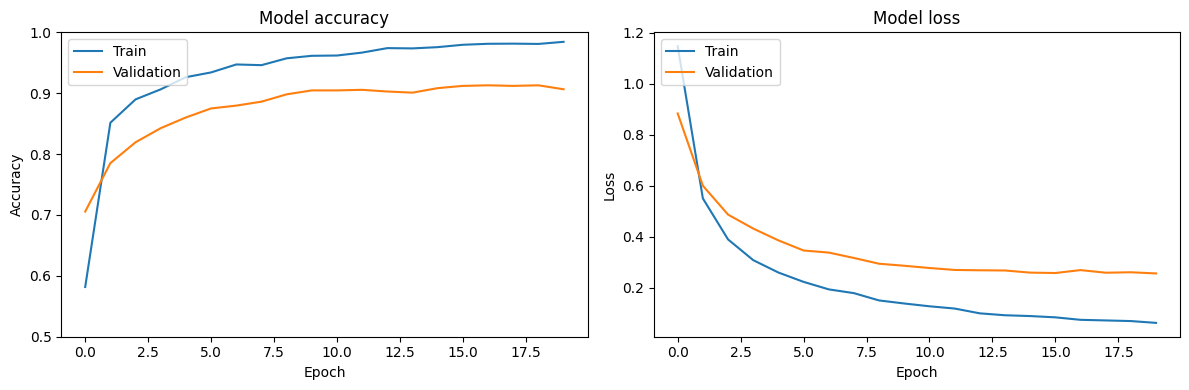

Found 1093 images belonging to 5 classes.
46/46 [==============================] - 51s 1s/step


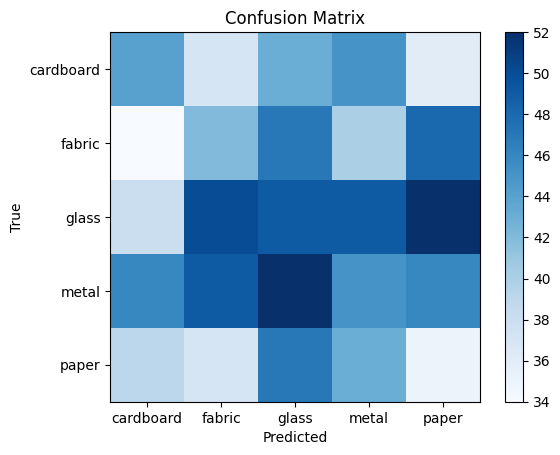

              precision    recall  f1-score   support

   cardboard       0.22      0.21      0.22       205
      fabric       0.20      0.20      0.20       211
       glass       0.21      0.21      0.21       238
       metal       0.20      0.19      0.20       238
       paper       0.16      0.17      0.17       201

    accuracy                           0.20      1093
   macro avg       0.20      0.20      0.20      1093
weighted avg       0.20      0.20      0.20      1093



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0.5, 1)  # Set y-axis range from 0 to 1
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Create and display a confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title='Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the model on the test dataset
test_generator = original_datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Validation data
)

test_steps = len(test_generator)
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_steps)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_labels)

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

**Save trained weight**

In [ ]:
from datetime import date, datetime
model.save(weight_dir+f'trash-{date.today()}-{datetime.now().strftime("%H-%M")}.h5')

**Appendix**

Architecture

In [ ]:
temp1 = MobileNetV3Large(weights='imagenet', classes=5, include_top=False, dropout_rate=0.5, input_shape=None, minimalistic=False,)
print(temp1)